From: http://connor-johnson.com/2014/03/04/fractal-dimension-and-box-counting/

In [1]:
import numpy as np, scipy, scipy.stats
from pandas import Series, DataFrame
import scipy.optimize

In [2]:
L = 64
U = list()
rate = L / 6.0
N = scipy.stats.poisson( rate ).rvs()
U = list( scipy.stats.uniform(0,L).rvs(N) )
 
def matern_children( U, rate, nbhd ):
    T = list()
    for i in range( len( U ) ):
        M = scipy.stats.poisson( rate ).rvs()
        for j in range( M ):
            T.append( scipy.stats.uniform( U[i]-nbhd, 2*nbhd ).rvs() )
    return T
 
nbhd = 2.0
U = matern_children( U, rate, nbhd )
U = matern_children( U, rate, nbhd/4.0 )
U = matern_children( U, rate, nbhd/8.0 )
U = matern_children( U, rate, nbhd/16.0 )

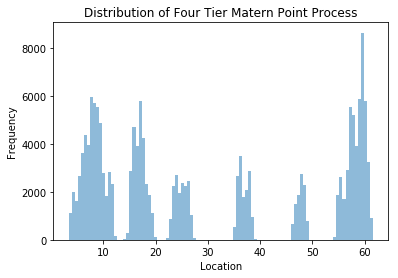

In [14]:
import matplotlib.pyplot as plt
plt.hist( U, 100, alpha=0.5 ) ;
plt.title('Distribution of Four Tier Matern Point Process')
plt.ylabel('Frequency') ; xlabel('Location') ;
plt.savefig('matern_fractal_distribution.png', fmt='png', dpi=100 )

In [20]:
def count_boxes( data, box_size, M ):
    data = Series( data )
    N = np.int( np.floor( M / box_size ) )
    counts = list()
    for i in range( N ):
        condition = ( data >= i*box_size )&( data < (i+1)*box_size )
        subset = data[ condition ]
        counts.append( subset.count() )
    counts = [ i for i in counts if i != 0 ]
    return len( counts )
 
r = np.array([ L/(2.0**i) for i in range(20,0,-1) ])
N = [ count_boxes( U, ri, L ) for ri in r ]

In [21]:
def f( x, A, Df ):
    '''
    User defined function for scipy.optimize.curve_fit(),
    which will find optimal values for A and Df.
    '''
    return Df * x + A
 
popt, pcov = scipy.optimize.curve_fit( f, np.log( 1./r ), np.log( N ) )
A, Df = popt

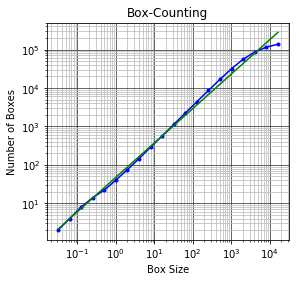

In [22]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
plt.plot( 1./r, N, 'b.-' )
ax.plot( 1./r, np.exp(A)*1./r**Df, 'g', alpha=1.0 )
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_aspect(1)
plt.xlabel('Box Size')
plt.ylabel('Number of Boxes')
plt.grid(which='minor', ls='-', color='0.75')
plt.grid(which='major', ls='-', color='0.25')
plt.title('Box-Counting')
plt.savefig('fractal_box_counting.png',fmt='png',dpi=100)

In [23]:
import statsmodels.formula.api as sm
 
Y = np.log( N )
X = np.log( 1./r )
T = np.vstack((Y,X,np.ones_like(X))).T
 
df = DataFrame( T, columns=['N(r)','Df','A'] )
Y = df['N(r)']
X = df[['Df','A']]
result = sm.OLS( Y, X ).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   N(r)   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     4448.
Date:                Fri, 05 Jan 2018   Prob (F-statistic):           5.21e-23
Time:                        14:09:47   Log-Likelihood:                 1.2380
No. Observations:                  20   AIC:                             1.524
Df Residuals:                      18   BIC:                             3.515
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Df             0.8946      0.013     66.695      0.000       0.866       0.923
A              3.8557      0.068     56.700      0.000       3.713       3.999
==============================================================================
Omnibus:                       11.319   Durbin-Watson:                   0.400
Prob(Omnibus):                  0.003   Jarque-Bera (JB):                9.270
Skew:                          -1.228   Prob(JB):                      0.00971
Kurtosis:                       5.256   Cond. No.                         6.53
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""